In [2]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import itertools

import pandas as pd

model = ConcreteModel()

def fsmodel():
    model = ConcreteModel()
    
    # 5D Array
    model.gen = Set(initialize=[1, 2])  # Generators
    model.Periods = Set(initialize=[1, 2, 3])  # Time periods
    model.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    
    # Total Scenarios
    
    file_path = 'newgenexp.xlsx'
    sheet_name = 'DIC'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    c = {}
    for i in range(0,df.shape[0]):
        c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
    model.c = Param(model.gen, initialize=c)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'FIXOP'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    f = {}
    for i in range(0,df.shape[0]):
        f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]
    model.f = Param(model.gen,model.Periods, initialize=f)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'Additional cost'  # Specify the sheet name or sheet number
    
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    g = {}
    for i in range(0,df.shape[0]):
        g[df['Day'][i]] = df['Cost'][i]
    model.g = Param(model.days, initialize=g)
    
    
    
    d = {}
    
    sheet_name = 'Demand'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        d[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
        
                           
                   
    model.d = Param(model.Periods,model.days, initialize=d)  # Fixed cost per unit capacity of generator j
    
                           
       
    a = {}    
    sheet_name = 'Availability'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        a[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
        
                           
    model.a = Param(model.Periods,model.days,model.gen, initialize=a)  # Fixed cost per unit capacity of generator j
    
    # Variables
    model.x = Var(model.gen, domain=NonNegativeReals)  # Installed capacity of generator j
    model.y = Var(model.days,model.Periods, model.gen, domain=NonNegativeReals)  # Operating level of generator j
    model.y_purchased = Var(model.days,model.Periods, domain=NonNegativeReals)  # Additional capacity purchased
    # Objective function
    def objective_rule(model):
        fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(sum(model.f[j,i] * model.y[s,i,j] for j in model.gen) + model.g[s] * model.y_purchased[s,i] for i in model.Periods) for s in model.days)
        return fixed_cost + operating_cost
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, s, i):
        return sum(model.y[s,i,j] for j in model.gen) + model.y_purchased[s,i] >= model.d[s,i]
    model.demand_satisfaction_constraint = Constraint(model.days,model.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model,s,i, gen):
        return model.y[s,i,gen] <= model.a[s,i,gen] * model.x[gen]
    model.availability_constraint = Constraint(model.days,model.Periods,model.gen, rule=availability_rule)
    return model


In [23]:
def hlmodel(param_val):
    model = ConcreteModel()
    
    # 5D Array
    model.gen = Set(initialize=[1, 2])  # Generators
    model.Periods = Set(initialize=[1, 2, 3])  # Time periods
    model.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    
    # Total Scenarios
    
    file_path = 'newgenexp.xlsx'
    sheet_name = 'DIC'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    c = {}
    for i in range(0,df.shape[0]):
        c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
    model.c = Param(model.gen, initialize=c)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'FIXOP'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    f = {}
    for i in range(0,df.shape[0]):
        f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]
    model.f = Param(model.gen,model.Periods, initialize=f)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'Additional cost'  # Specify the sheet name or sheet number
    
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    g = {}
    for i in range(0,df.shape[0]):
        g[df['Day'][i]] = df['Cost'][i]
    model.g = Param(model.days, initialize=g)
    
    
    
    d = {}
    
    sheet_name = 'Demand'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        d[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
        
                           
                   
    model.d = Param(model.Periods,model.days, initialize=d)  # Fixed cost per unit capacity of generator j
    
                           
       
    a = {}    
    sheet_name = 'Availability'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        a[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
        
                           
    model.a = Param(model.Periods,model.days,model.gen, initialize=a)  # Fixed cost per unit capacity of generator j
    
    # Variables
    model.x = Var(model.gen, domain=NonNegativeReals)  # Installed capacity of generator j
    model.y = Var(model.gen, domain=NonNegativeReals)  # Operating level of generator j
    model.y_purchased = Var(domain=NonNegativeReals)  # Additional capacity purchased
    # Objective function
    
    def objective_rule(model):
        fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(sum(model.f[j,i] * model.y[j] for j in model.gen) + model.g[s] * model.y_purchased for i in model.Periods) for s in model.days)
        return fixed_cost + operating_cost
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model):
        return sum(model.y[j] for j in model.gen) + model.y_purchased >= sum(model.d[s,i] for s in model.days for i in model.Periods)
    model.demand_satisfaction_constraint = Constraint(rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, gen):
        return model.y[gen] <= sum((model.a[s,i,gen] for s in model.days for i in model.Periods)) * model.x[gen]*param_val[gen-1]
    model.availability_constraint = Constraint(model.gen, rule=availability_rule)

    def min_cap_rule(model, gen):
        return model.x[gen] >= param_val[2]
    model.mincap_constraint = Constraint(model.gen, rule=min_cap_rule)
    opt = SolverFactory('gurobi')
    results = opt.solve(model)
    #print(param_val)
    #model.pprint()
    #model.display()
    if results.solver.termination_condition == TerminationCondition.infeasible:
        print(param_val)
        return 10**20
    #model.pprint()
    xval = {1:model.x[1](),2:model.x[2]()}
    return xval
    

In [38]:
opt_list = []
def llmodel(xval):
    if(xval==10**20):
        return 10**20
    model = fsmodel()
    def cap_fix_rule(model, gen):
        return model.x[gen] == xval[gen]
    model.cap_fix_constraint = Constraint(model.gen, rule=cap_fix_rule)
    opt = SolverFactory('gurobi')
    results = opt.solve(model)
    
    
    #model.display()
    if results.solver.termination_condition == TerminationCondition.infeasible:
        if(len(opt_list)>=1):
            opt_list.append(opt_list[-1])
        else:
            opt_list.append(10**20)
        return 10**20
    if(len(opt_list)>=1):
        opt_list.append(min(opt_list[-1],value(model.obj)))
    else:
        opt_list.append(value(model.obj))
    return value(model.obj)

In [39]:
def MBBF(param):
    xval = hlmodel(param)
    print(xval)
    obj = llmodel(xval)
    return obj


In [40]:
from mads import mads
design_variables = [1,1,0]
bounds_lower = [0,0,0]
bounds_upper = [1.5,1.5,2100]

dp_tol = 1E-6                               # Minimum poll size stopping criteria
nitermax = 500                            # Maximum objective function evaluations
dp = 0.1                                    # Initial poll size as percent of bounds
dm = 0.1                                   # Initial mesh size as percent of bounds
opt_obj,opt_par = mads.orthomads(design_variables, bounds_upper, bounds_lower, MBBF, dp, dm, dp_tol, nitermax, True, True)

{1: 0.0, 2: 1831.1860515021458}
{1: 105.0, 2: 1610.3657051601956}
{1: 105.0, 2: 1595.2743786805067}
{1: 105.0, 2: 1871.5060897807678}
Optimal:  401829.4174834706 Parameters: [ 0.9250000000  0.9250000000  105.0000000000] Iter/Eval: 1 3
{1: 1653.7455426356587, 2: 0.0}
{1: 210.0, 2: 1663.546566523605}
{1: 1494.8998958333336, 2: 315.0}
{1: 0.0, 2: 1703.4288851182748}
{1: 1905.61568627451, 2: 210.0}
Optimal:  367377.7602941176 Parameters: [ 0.8500000000  0.7750000000  210.0000000000] Iter/Eval: 2 8
{1: 1435.0909420289854, 2: 210.0}
{1: 210.0, 2: 1851.0444264006494}
{1: 420.0, 2: 1300.993512326579}
{1: 2539.680654761905, 2: 0.0}
{1: 1641.7774509803924, 2: 630.0}
Optimal:  363864.9813988095 Parameters: [ 0.7000000000  0.4750000000  0.0000000000] Iter/Eval: 3 13
{1: 420.0, 2: 1663.1853478391051}
{1: 1124.4386217948716, 2: 420.0}
{1: 4087.659895833334, 2: 840.0}
{1: 2175.618154761905, 2: 420.0}
{1: 2049.5274509803926, 2: 210.0}
{1: 4361.616927083334, 2: 105.0}
Optimal:  362822.3251488095 Parame

In [43]:
MBBF(opt_par)

{1: 2513.422511699659, 2: 911.0127714989358}


357414.0719775436

In [42]:
opt_par

array([ 0.6553360206,  0.1477091948,  911.0127714989])

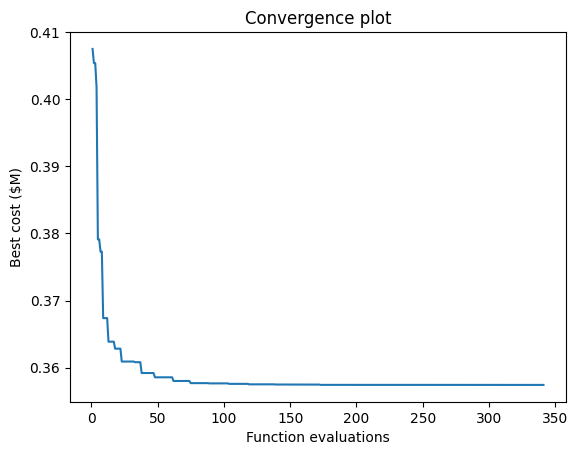

In [51]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(range(1,len(opt_list)+1), np.array(opt_list)/10**6)
plt.ylabel('Best cost ($M)')
plt.xlabel('Function evaluations')
plt.title('Convergence plot')
plt.savefig('PAMSO_convergence.pdf')
plt.show()

In [50]:
np.array(opt_list).10

array([ 407520.7540021460,  405413.3497429884,  405413.3497429884,
        401829.4174834706,  379125.2582364341,  379125.2582364341,
        377283.0286979167,  377283.0286979167,  367377.7602941176,
        367377.7602941176,  367377.7602941176,  367377.7602941176,
        363864.9813988095,  363864.9813988095,  363864.9813988095,
        363864.9813988095,  363864.9813988095,  362822.3251488095,
        362822.3251488095,  362822.3251488095,  362822.3251488095,
        362822.3251488095,  360900.0751488095,  360900.0751488095,
        360900.0751488095,  360900.0751488095,  360900.0751488095,
        360900.0751488095,  360900.0751488095,  360900.0751488095,
        360900.0751488095,  360900.0751488095,  360802.1522889843,
        360802.1522889843,  360802.1522889843,  360802.1522889843,
        360802.1522889843,  359189.3549574830,  359189.3549574830,
        359189.3549574830,  359189.3549574830,  359189.3549574830,
        359189.3549574830,  359189.3549574830,  359189.3549574